In [20]:
import seaborn as sn
from systems import EpicActionRecogintionShapleyClassifier
from datasets.pickle_dataset import MultiPickleDataset
from models.esvs import N_MTRN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from frame_sampling import RandomSampler
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
def no_collate(args):
    return args

trainloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/67217_train_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)
testloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/9668_val_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=False)

In [21]:
class V_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(256 * frame_count, 1024)
#         self.fc1_2 = nn.Linear(4096, 1024)
#         self.d1 = nn.Dropout(p=0.7)
        self.d2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3_verb = nn.Linear(512, 97)
    
    def forward(self, x):
        x = x.view(-1, 256 * self.frame_count)
        x = F.relu(self.fc1(x))
#         x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
        x = self.d2(x)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc3_verb(x)
        
        return x

In [22]:
# v_models = [V_MTRN(frame_count=i) for i in range(1,9)]
v_model = V_MTRN(frame_count=4)
v_model.load_state_dict(torch.load('mtrn_verb_frames=4_lr=1e-4_hl=1024_dc=2.pt', map_location='cpu'))

# n_models = [N_MTRN(frame_count=i, hidden_layer_size=2048, dropout_count=2) for i in range(1,9)]
frame_samplers = [RandomSampler(frame_count=i, snippet_length=1, test=False) for i in range(1,9)]
# for i in range(len(v_models)):
#     try:
#         v_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'sh_mtrn-type=verb-frames={i+1}-batch_size=512-lr=1e-05_hl=2048_dc=2.pt', map_location='cpu'))
#     except FileNotFoundError:
#         print(f'no verb model for {i+1} frames')
#     try:
#         n_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'sh_mtrn-type=noun-frames={i+1}-batch_size=512-lr=1e-05_hl=2048_dc=2.pt', map_location='cpu'))
#     except FileNotFoundError:
#         print(f'no noun model for {i+1} frames')

In [12]:
verbs = pd.read_csv('../datasets/epic-100/labels/EPIC_100_verb_classes.csv')['key'].to_dict()
nouns = pd.read_csv('../datasets/epic-100/labels/EPIC_100_noun_classes.csv')['key'].to_dict()

In [42]:
def get_per_class_accuracy(model, sampler):
    
    def compute_accuracy(preds, labels) -> float:
        return float((labels == preds).sum()) / len(labels)

    if isinstance(model, V_MTRN):
        classes = verbs
        m_type="verb"
    else:
        classes = nouns
        m_type="noun"

    classifier = EpicActionRecogintionShapleyClassifier(
        model,
        torch.device("cpu"),
        None,
        sampler,
        sampler,
        None,
        testloader,
        m_type
    )
    
    correct_pred = {classname: 0 for classname in classes.keys()}
    incorrect_pred = {classname: {class_n: 0 for class_n in classes.keys()} for classname in classes.keys()}
    total_pred = {classname: 0 for classname in classes.keys()}
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    model.eval()
    with torch.no_grad():
        
        validation_results = {
            'loss': [],
            'accuracy': [],
            'preds': [],
            'labels': []
        }
            
        for idx, data in tqdm(enumerate(testloader),total=len(testloader),dynamic_ncols=True):
            
            batch, labels = classifier._sample_frames(data)
            
            logits = model(batch.to(torch.device('cpu')))
            preds = logits.argmax(-1).cpu().numpy()
            label_classes = labels[f'{m_type}_class']
            
#             print(f'pred: {preds}, label: {label_classes.cpu().numpy()}')

            for label, pred in zip(label_classes.cpu().numpy(), preds):
                if label == pred:
                    correct_pred[label] += 1
                incorrect_pred[label][pred] += 1
                total_pred[label] += 1
                        
            validation_results['preds'].extend(list(preds))
            validation_results['labels'].extend(list(label_classes.cpu().numpy()))
            
    validation_results['accuracy'] = compute_accuracy(
        np.array(validation_results["labels"]), 
        np.array(validation_results["preds"])
    )
        
        
    print(validation_results['accuracy'])
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    for classname, correct in correct_pred.items():
        try:
            accuracy = 100 * float(correct) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f}%".format(classes[classname], accuracy))
        except ZeroDivisionError:
            print("Did not predict class {:5s}".format(classes[classname]))
            
    return classes, incorrect_pred

In [43]:
classes, incorrect_pred = get_per_class_accuracy(model=v_model, sampler=frame_samplers[3])

  0%|          | 1/9668 [00:00<16:42,  9.64it/s]

Classifier, model: <class '__main__.V_MTRN'>, type: verb, frames: 4


100%|██████████| 9668/9668 [00:10<00:00, 926.12it/s] 

0.28227141083988416
Accuracy for class take  is: 56.1%
Accuracy for class put   is: 28.7%
Accuracy for class wash  is: 47.7%
Accuracy for class open  is: 32.0%
Accuracy for class close is: 19.8%
Accuracy for class insert is: 5.8%
Accuracy for class turn-on is: 4.3%
Accuracy for class cut   is: 20.5%
Accuracy for class turn-off is: 0.9%
Accuracy for class pour  is: 6.2%
Accuracy for class mix   is: 16.0%
Accuracy for class move  is: 0.0%
Accuracy for class remove is: 0.9%
Accuracy for class throw is: 19.3%
Accuracy for class dry   is: 11.3%
Accuracy for class shake is: 9.1%
Accuracy for class scoop is: 7.5%
Accuracy for class adjust is: 3.1%
Accuracy for class squeeze is: 2.0%
Accuracy for class peel  is: 7.9%
Accuracy for class empty is: 2.1%
Accuracy for class press is: 4.8%
Accuracy for class flip  is: 0.0%
Accuracy for class turn  is: 0.0%
Accuracy for class check is: 0.0%
Accuracy for class scrape is: 0.0%
Accuracy for class fill  is: 6.5%
Accuracy for class apply is: 0.0%
Accuracy

In [50]:
class_list = list(classes.values())
cnf = np.array([[x for x in y.values()] for y in incorrect_pred.values()])
row_sums = cnf.sum(axis=1)
new_matrix = cnf / row_sums[:, np.newaxis]
new_matrix = np.nan_to_num(new_matrix)

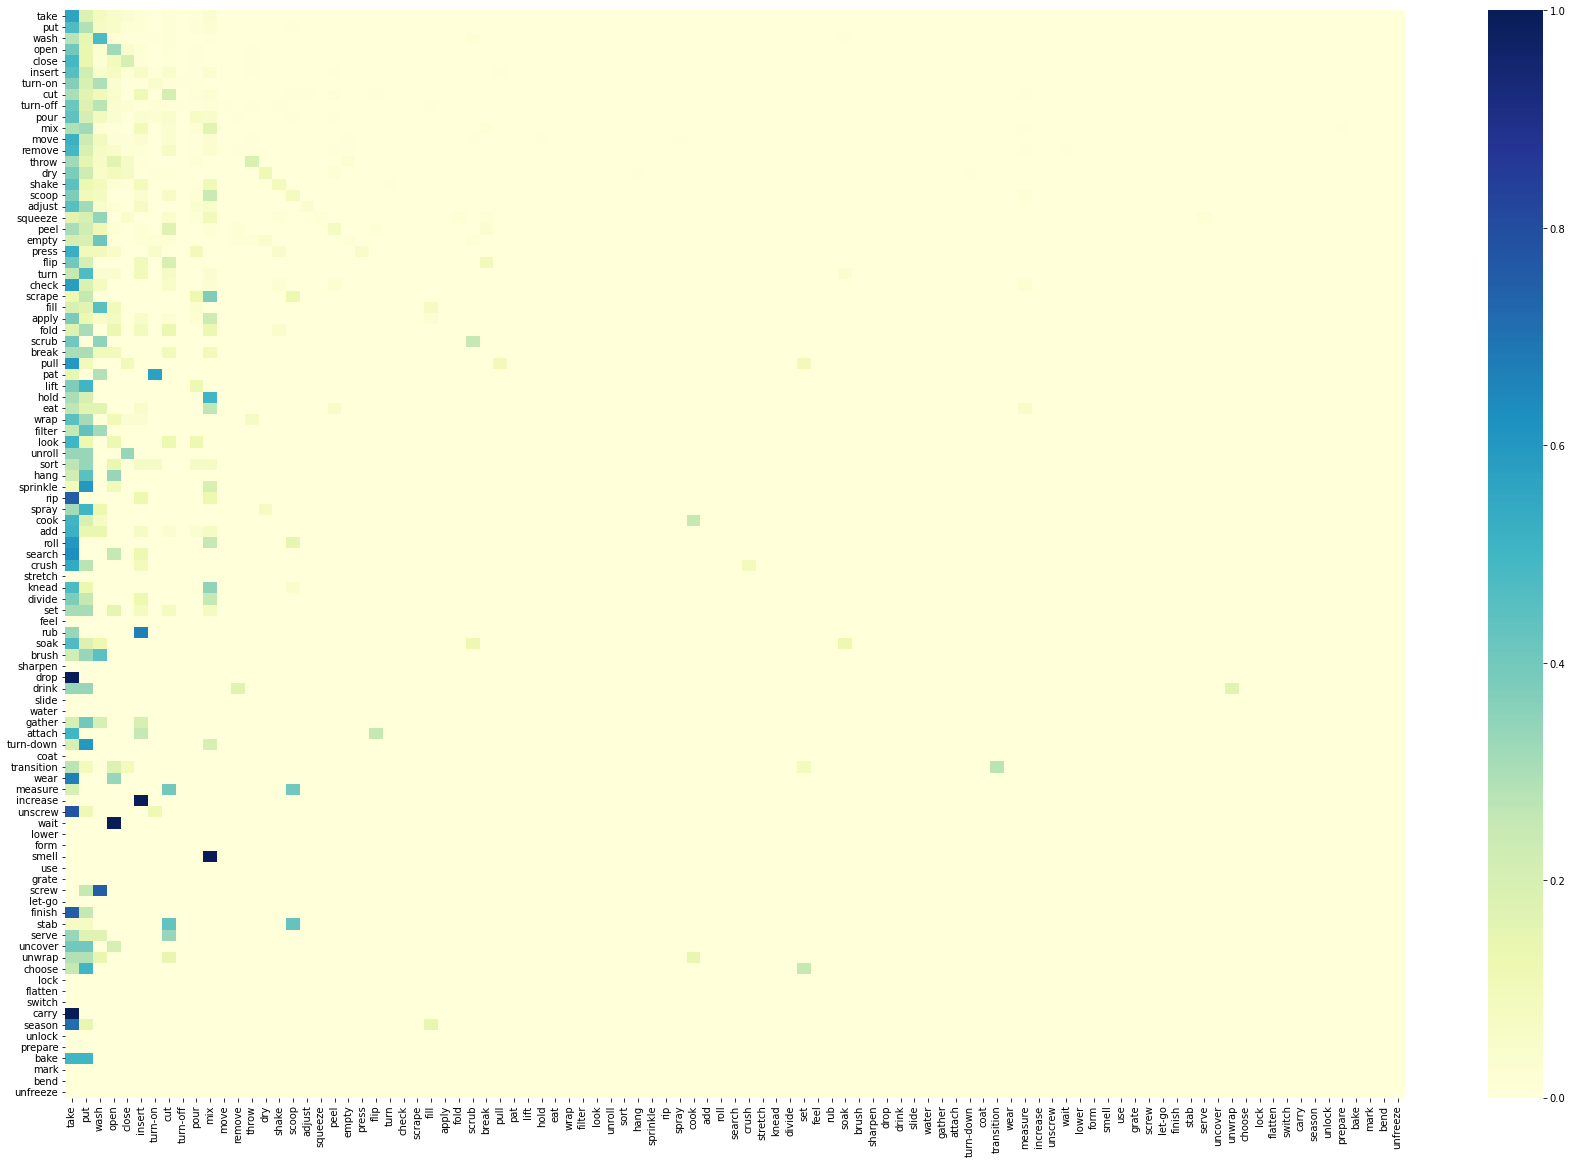

In [53]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(new_matrix, index = [i for i in class_list],
                  columns = [i for i in class_list])
plt.figure(figsize = (30,20))
cnf_matrix = sn.heatmap(df_cm, annot=False, cmap="YlGnBu")

In [ ]:
cnf_matrix.get_figure().savefig('conf.png', dpi=72)